# Exploratory Data Analysis - Sales

In [1]:
import pandas as pd
import numpy as np
import datetime
import time

import matplotlib.pyplot as plt
import seaborn as sns

import requests

pd.options.display.max_columns = None

## Load Data

In [2]:
sales = pd.read_csv("./data/sales_parcels_181920.csv")
sales["Year"] = sales["dateYM"].apply(lambda x: x[:4])
sales

,parcel,dateYMD,dateYM,LpriceUSD,x,y,road,district,districtNm,distOrigin,distRoad,distPlaza,distDistrict,distOriginSQ,distRoadSQ,distPlazaSQ,distDistrictSQ,payMANA,payETH,YM_2018-11,YM_2018-12,YM_2019-01,YM_2019-02,YM_2019-03,YM_2019-04,YM_2019-05,YM_2019-06,YM_2019-07,YM_2019-08,YM_2019-09,YM_2019-10,YM_2019-11,YM_2019-12,YM_2020-01,YM_2020-02,YM_2020-03,YM_2020-04,YM_2020-05,YM_2020-06,YM_2020-07,YM_2020-08,YM_2020-09,YM_2020-10,YM_2020-11,YM_2020-12,Year
0,1157920892373161954235709850086879078294502189...,2018-10-11T19:59:29,2018-10,11.448494,-70,145,0,0,NaN,0.711526,0.019858,0.587783,0.029555,0.506269,0.000394,0.345489,0.000874,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018
1,1157920892373161954235709850086879078444226431...,2018-10-12T07:36:47,2018-10,11.433882,-27,-21,0,0,NaN,0.151156,0.187336,0.171834,0.268956,0.022848,0.035095,0.029527,0.072337,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018
2,22458636216781938588582724090496701956068,2018-10-12T08:56:08,2018-10,10.544025,65,-28,0,0,NaN,0.312757,0.121196,0.160834,0.091394,0.097817,0.014688,0.025868,0.008353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018
3,1157920892373161954235709850086879078382975605...,2018-10-12T09:39:19,2018-10,10.768843,-44,101,0,0,NaN,0.486841,0.069501,0.246617,0.066499,0.237014,0.004830,0.060820,0.004422,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018
4,28924001188279769394386841631700297973621,2018-10-12T11:35:52,2018-10,10.664293,84,-139,0,0,NaN,0.717701,0.109216,0.549907,0.007389,0.515095,0.011928,0.302397,0.000055,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6102,1157920892373161954235709850086879078399989723...,2020-12-30T07:42:25,2020-12,10.186785,-39,113,0,0,NaN,0.528259,0.019858,0.290871,0.029555,0.279058,0.000394,0.084606,0.000874,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2020
6103,1157920892373161954235709850086879078403392547...,2020-12-30T16:30:39,2020-12,11.107360,-38,114,0,0,NaN,0.531025,0.009929,0.289130,0.022166,0.281987,0.000099,0.083596,0.000491,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2020
6104,1157920892373161954235709850086879078376169957...,2020-12-30T23:21:26,2020-12,10.186785,-46,113,0,0,NaN,0.539145,0.019858,0.336994,0.081277,0.290677,0.000394,0.113565,0.006606,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2020
6105,1157920892373161954235709850086879078454434902...,2020-12-31T13:15:59,2020-12,10.517592,-24,-5,0,0,NaN,0.108335,0.039715,0.119145,0.240561,0.011736,0.001577,0.014196,0.057870,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2020


## Descriptive Statistics

### Selling Price Trend

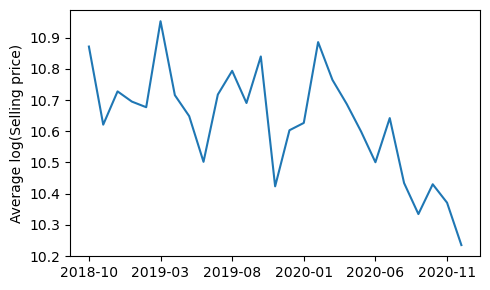

In [3]:
plt.rcParams["figure.figsize"] = (5,3); plt.rcParams["figure.dpi"] = 100
sales.groupby("dateYM")["LpriceUSD"].mean().plot()
plt.ylabel("Average log(Selling price)")
plt.xlabel("")
plt.tight_layout()
plt.savefig("./figures/sales_yearmonth.png")
# plt.show()

### Selling Price by Year

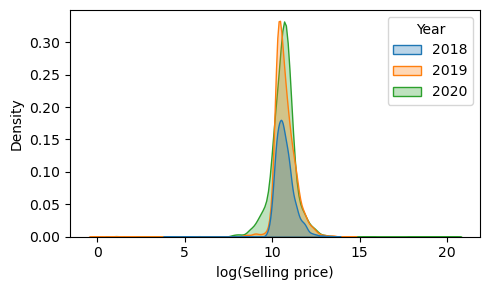

In [4]:
# log-transformed selling prices in USD
plt.rcParams["figure.figsize"] = (5,3); plt.rcParams["figure.dpi"] = 100
sns.kdeplot(data=sales, x="LpriceUSD", hue="Year", fill=True, alpha=.3)
plt.xlabel("log(Selling price)")
plt.tight_layout()
plt.savefig("./figures/sales_year.png")
# plt.show()

### Yearly Average Selling Price by Parcel

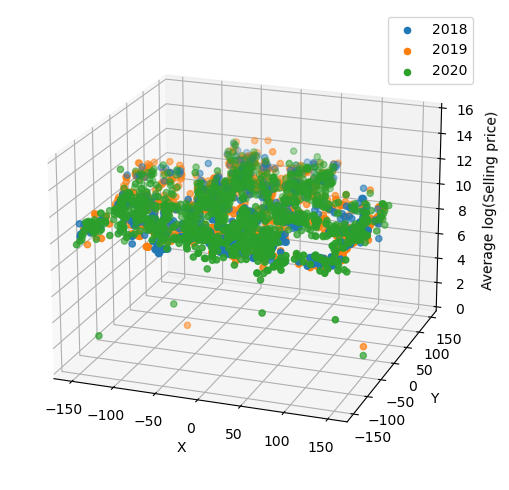

In [5]:
fig = plt.figure(figsize=(5,5)); plt.rcParams["figure.dpi"] = 100
ax = plt.axes(projection="3d")

for y in [2018,2019,2020]:
    tmp = sales[sales.Year==str(y)].groupby(["x","y"])["LpriceUSD"].mean().to_frame("AVG_LpriceUSD").reset_index()
    ax.scatter3D(tmp.x, tmp.y, tmp["AVG_LpriceUSD"], label=str(y))

ax.set_xlabel("X"); ax.set_ylabel("Y")
ax.set_zlabel("Average log(Selling price)")
ax.set_zlim(0,16)
ax.view_init(20, 290)

plt.legend(); plt.tight_layout()
plt.savefig("sales_parcels.png", dpi=300)
# plt.show()

## Pricing Models

### Hedonic Regression Model

$$\begin{equation}
\begin{split}
    \log{(Selling \text{ } price_{it})} &= \alpha + X_{i} \beta + \delta_{t} + \epsilon_{it}
\end{split}
\end{equation}$$

In [6]:
import statsmodels.api as sm
from linearmodels import PanelOLS

In [7]:
sales["dateYM"] = sales["dateYM"].apply(lambda x: datetime.datetime.strptime(str(x), "%Y-%m"))
sales = sales.set_index(["parcel","dateYM"])

In [8]:
X = sm.add_constant(sales.drop(columns=["LpriceUSD","dateYMD","Year","x","y","district","districtNm"]))
y = sales.LpriceUSD
result = PanelOLS(y, X, entity_effects=False).fit(cov_type="clustered", cluster_entity=True)
print(result)

                          PanelOLS Estimation Summary                           
Dep. Variable:              LpriceUSD   R-squared:                        0.2706
Estimator:                   PanelOLS   R-squared (Between):              0.3614
No. Observations:                6107   R-squared (Within):               0.1667
Date:                Thu, Mar 24 2022   R-squared (Overall):              0.2706
Time:                        14:25:02   Log-likelihood                   -6312.0
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      60.841
Entities:                        3284   P-value                           0.0000
Avg Obs:                       1.8596   Distribution:                 F(37,6069)
Min Obs:                       1.0000                                           
Max Obs:                       23.000   F-statistic (robust):             48.063
                            

C:\Users\user\anaconda3\lib\site-packages\linearmodels\panel\data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


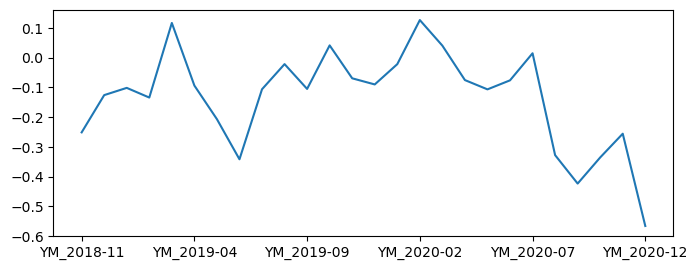

In [9]:
plt.rcParams["figure.figsize"] = (8,3)
result.params[[c for c in result.params.index if "YM_" in c]].plot()
plt.show()

In [10]:
sales["LpriceUSD_pred"] = result.predict(sm.add_constant(sales.drop(columns=["LpriceUSD","dateYMD","Year","x","y",
                                                                             "district","districtNm"])))

C:\Users\user\anaconda3\lib\site-packages\linearmodels\panel\data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


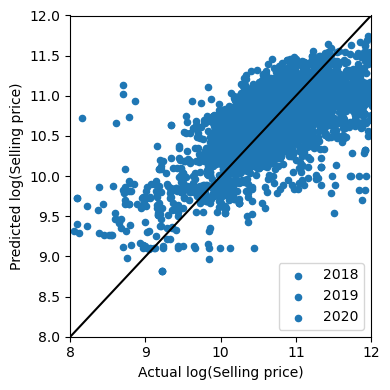

In [11]:
plt.rcParams["figure.figsize"] = (4,4); fig, ax = plt.subplots()

for y in [2018,2019,2020]:
    sales[sales.Year==str(y)].plot(x="LpriceUSD", y="LpriceUSD_pred", kind="scatter", ax=ax, label=str(y))

ax.axline([0, 0], [1, 1], c="black")
ax.set_xlim([8,12]); ax.set_ylim([8,12])
ax.set_xlabel("Actual log(Selling price)"); ax.set_ylabel("Predicted log(Selling price)")
plt.legend()
plt.tight_layout()
plt.savefig("./figures/eval_hedonic.png")
# plt.show()